In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pyreadr

In [2]:
def extremal_coefficient(h, method, r, s):
    if method=="powexp":
        res = 1+np.sqrt(1-(np.exp(-np.power(np.abs(h)/r,s))/2))
    elif method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(np.power(np.abs(h)/r,s))/2,loc = 0, scale = 1)
    
    return res    

In [3]:
def error_function(h, method, true, est):
    r_true, s_true = true
    r_est, s_est = est
    error = np.power(extremal_coefficient(h, method, r_true, s_true)- extremal_coefficient(h, method, r_est, s_est),2)
    return error

# Calculate integral metric over test set from exp 2

In [7]:
exp = "exp_3"
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy()
schlather_params = pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy()
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_opt.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"powexp_single_image_fit_opt.RData")["results"].to_numpy()[:,1:]
cnn_brown = np.load(path+"cnn_brown.npy")
cnn_schlather = np.load(path+"cnn_powexp.npy")

In [9]:
#Brown results
true_params = brown_params
pl_pred = brown_res
dim = len(true_params)
pl_error = np.zeros(shape = dim)
cnn_error = np.zeros(shape = dim)
for i in range(dim):
    cnn = quad(error_function, 0, 30, args=("brown", true_params[i,], cnn_brown[i,]))
    pl = quad(error_function, 0, 30, args=("brown", true_params[i,], pl_pred[i,]))
    pl_error[i] = pl[0]        
    cnn_error[i] = cnn[0]

In [11]:
print(pl_error.mean())
print(cnn_error.mean())

2.3873111127712745
0.1794831704661004


In [12]:
#Schlather results
true_params = schlather_params
pl_pred = schlather_res
dim = len(true_params)
pl_error = np.zeros(shape = dim)
cnn_error = np.zeros(shape = dim)
for i in range(dim):
    cnn = quad(error_function, 0, 30, args=("brown", true_params[i,], cnn_schlather[i,]))
    pl = quad(error_function, 0, 30, args=("brown", true_params[i,], pl_pred[i,]))
    pl_error[i] = pl[0]        
    cnn_error[i] = cnn[0]

In [13]:
print(pl_error.mean())
print(cnn_error.mean())

3.056515194146945
0.7065025837853343


In [154]:
x = np.linspace(0,50,1000)
error = error_function(x, "brown", true_params[1], pl_pred[1])
true =  extremal_coefficient(x, "brown", true_params[1,0], true_params[1,1])
est = extremal_coefficient(x, "brown", pl_pred[1,0], pl_pred[1,1])

Text(0.5, 1.0, 'Extremal coefficient')

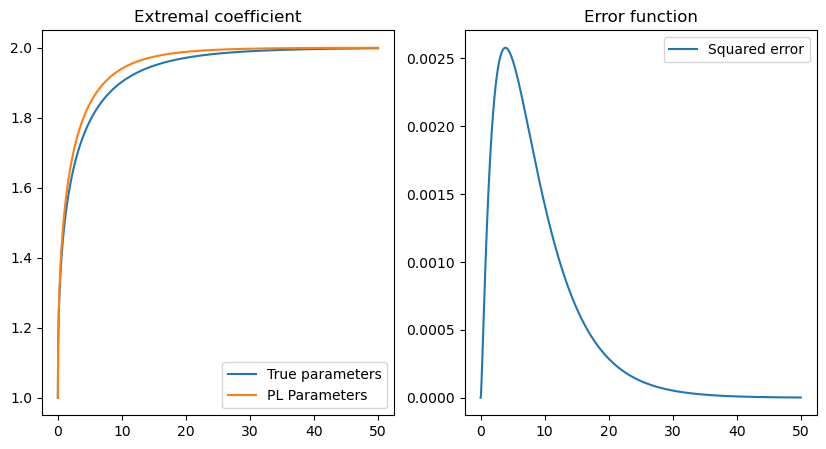

In [155]:
fig, axs = plt.subplots(1,2 ,figsize = (10,5))
axs[1].plot(x,error)
axs[0].plot(x,true)
axs[0].plot(x, est)
axs[0].legend(["True parameters", "PL Parameters"])
axs[1].legend(["Squared error"])
axs[1].set_title("Error function")
axs[0].set_title("Extremal coefficient")